<a href="https://colab.research.google.com/github/pedrotorres08/CNPQuniversal/blob/main/reliable_prossumer_stochastic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1- Introduction**<br>
**1.1 - Definitions**<br>
*Reliable prossumer* (RP): a low-voltage prossumer connected to the microgrid (POC MG) that has both distributed generation and distributed storage, and is able to operate off-grid for a certain period. In this project, it is assumed that the distributed generation is PV, and storage is a BESS
<br>

*   $P_{MG}$ - microgrid input power
*   $P_{BESS}$ - BESS power (optimizable)
*   $P_{IN}$ - Power of inflexible, non-critical loads
*   $P_{FN}$ - Power of flexible, non-critical loads (optimizable)
*   $P_{IC}$ - Power of inflexible, critical loads
*   $P_{FC}$ - Power of flexible, critical loads (optimizable)
*   $P_{DPV}$ - Distributed PV power
<br><br>
Here we define a flexible load those that have a certain degree of flexibility in its operation scheduling on a day-ahead basis (opposing to inflexible ones) and critical loads are those that for a given day-ahead schedule MUST operate irrespective of external source availability (i.e. MG), while non-critical loads are not constrained in this regard. Load classification varies from user-specific needs, but some examples can be given:<br>
*   Inflexible, non-critical: lighting 
*   Flexible, non-critical: entertaining (TV, etc)
*   Inflexible, critical: PC + internet for home office
*   Flexible, critical: electric shower
<br><br>

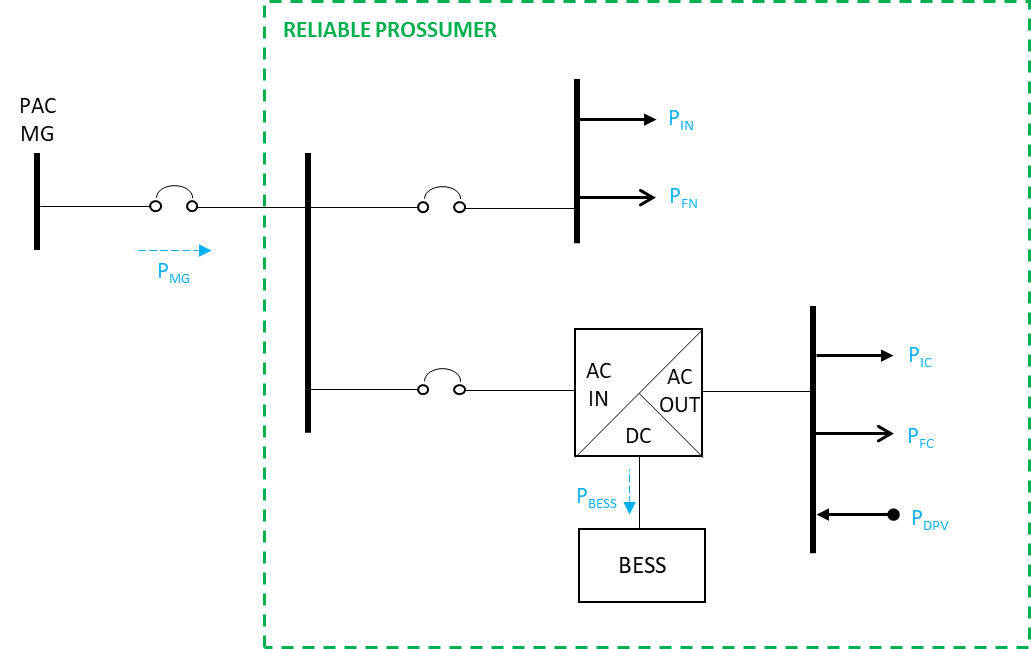
Power balance equation (time index omitted):<br>
$P_{MG}  = P_{BESS} + P_{FC} +  P_{IC} +  P_{FN} +  P_{IN} - P_{DPV}$<br>

**1.2 - Cost Function**<br>
The prossumer energy contract with the microgrid supplier is based on a day-ahead TOU tariff scheme, and also accounts the reliability of supply:
<br>
$C_{ES,t} = r_{t}*k_{t}*P_{MG,t} - p_{t}*r_{t}$<br>
Where:<br>
*   $C_{ES,t}$ - cost of energy supply, at a given time t<br>
*   $r_{t}$ - probability of guaranteed service at a given time t<br>
*   $p_{t}$ - penalty factor due unavailability of supply<br>
*   $k_{t}$ - energy supply tariff, at a given time t, in $/kWh<br>

$r_{t}$ is the probability of guaranteed service by the energy supply provider (ESP), on a TOU day-ahead basis, where $r_{t} = 1$ indicates that the ESP is 100 % confident that service will be available at a given time t in the next day. When a severe storm is forecasted, for instance, the ESP might reduce its confidence in service, thus adjusting $r_{t}$.<br>
$p_{t}$ is the penalty factor that accounts for interruptions in energy supply. This can be understood as a discount applied to the overall energy supply cost whenever service is interrupted. As $p_{t}$ is multiplied by $r_{t}$ the ESP is incentivized to determine accurate values for $r_{t}$ which in turn is an important input for the prossumer local energy scheduling.

**1.3 - Energy Management Controller**<br>
The RP energy management controller (EMC) schedules/dispatches the following variables: $P_{BESS}$, $P_{FC}$, $P_{FN}$. While $P_{DPV}$, $P_{IC}$, $P_{IN}$ are inputs that must be internally forecasted by the RP EMC. $r_{t}$, $p_{t}$ and $k_{t}$ are inputs external to the RP.

## **2 - Optimization model**
**2.1 - Cost Function**<br>
$min(\sum_{t=1}^{nt} C_{ES,t})$<br>where $nt$ is the number of timeslots for daily simulation (e.g. $nt = 24$ for an hourly timestep)<br><br>

**2.2 - Inputs**<br>
$r_{t}$, $p_{t}$, $k_{t}$, $P_{DPV,t}$, $\sum_{i=1}^{N_{IC}}P_{IC,i,t}$, $\sum_{i=1}^{N_{IN}}P_{IN,i,t}$<br>
where $N_{IN}$ is the number of inflexible, non-critical loads, and $N_{IC}$ is the number of inflexible, critical loads. <br><br>

**2.3 - Optimizing Variables**<br>
$P_{BESS,t}$, $\sum_{i=1}^{N_{FC}}P_{FC,i,t}$, $\sum_{i=1}^{N_{FN}}P_{FN,i,t}$<br>
where $N_{FN}$ is the number of flexible, non-critical loads, and $N_{FC}$ is the number of flexible, critical loads. <br><br>

**2.4 - Constraints**<br>


## **3 - Implementation**

In [17]:
#Conexao ao google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
#Instalar PVlib
!pip install -q pvlib

#Importar bibliotecas
from numpy import random
import numpy as np
from scipy import signal
from scipy.optimize import minimize, Bounds
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import matplotlib.ticker as tkr
import os
import itertools
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3
from pvlib import pvsystem, modelchain

In [19]:
#Definicoes iniciais
nt = 96 #Numero de timeslots
dtfv = {96: '15min', 24: '60min'}

In [20]:
#Ler Curva de Carga
filenameCCbt = r'/content/drive/MyDrive/DADOS_TESE/AUXILIARES_BDGD/CURVAS/TIP_CC_20200821_BT.parquet'
filenameCCmt = r'/content/drive/MyDrive/DADOS_TESE/AUXILIARES_BDGD/CURVAS/TIP_CC_20200821_MT.parquet'
CCbt = pd.read_parquet(filenameCCbt)
CCmt = pd.read_parquet(filenameCCmt)

CodBase = 201912371
CodCrvCrg = 'RES-Tipo1'
TipoDia = 'DU'
f_carga = 1
#Curva de carga
Pld = np.array(CCbt[(CCbt.CodBase == CodBase) & (CCbt.CodCrvCrg == CodCrvCrg) & (CCbt.TipoDia == TipoDia)].drop(columns=['Descr','CodBase','CodCrvCrg','TipoDia']).T)
Pld = [Pld[i][0]*f_carga for i in range(len(Pld))]

In [5]:
#Ler Inputs
filenameINP = r'/content/drive/MyDrive/DADOS_CNPQ/cnpq_data.xlsx'
dataINP = pd.read_excel(filenameINP)

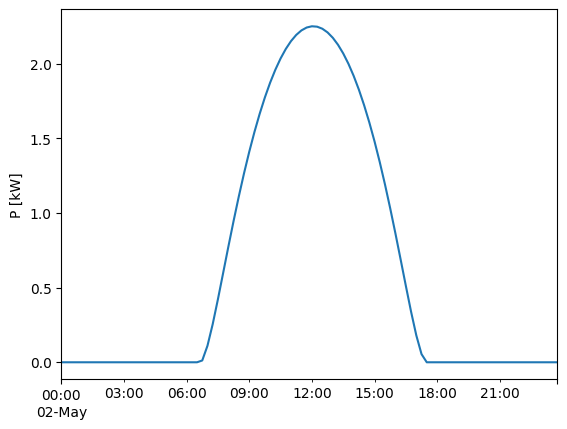

In [22]:
#Forecast FV (clear sky)
x_coord, y_coord, z_coord = -46.733727,-23.558533, 0
t0 = '2023-05-02 00:00'
tf = '2023-05-02 23:45'
freqfv = dtfv[nt]
gmt_fv = 'Brazil/East'

#Distributed PV generation
tilt_angle = 10
azimuth = 0
Pfv = 3.0 #Potencia em kWp
Pinv = 2.8 #Potencia em kW

loc = Location(y_coord, x_coord, gmt_fv, z_coord)
times = pd.date_range(start=t0, end=tf, freq=freqfv, tz=loc.tz)
cs = loc.get_clearsky(times)

array_kwargs = dict(module_parameters=dict(pdc0=Pfv, gamma_pdc=-0.004),temperature_model_parameters=dict(a=-3.56, b=-0.075, deltaT=3))
arrays = [pvsystem.Array(pvsystem.FixedMount(tilt_angle, azimuth), name='Gerador FV',**array_kwargs)]
system = pvsystem.PVSystem(arrays=arrays, inverter_parameters=dict(pdc0=Pinv))
mc = modelchain.ModelChain(system, loc, aoi_model='physical',spectral_model='no_loss')
mc.run_model(cs)

mc.results.ac.plot(label='Pfv_CA')
plt.ylabel('P [kW]')
plt.show()

#Pdpv
Pdpv = mc.results.ac

In [23]:
!pip install -q gurobipy  # install gurobipy

In [24]:
from getpass import getpass
WLSpass = getpass('Enter WLSSECRET: ')
LICpass = int(getpass('Enter LICENSEID: '))

Enter WLSSECRET: ··········
Enter LICENSEID: ··········


In [25]:
# Solve the following MIP:
import gurobipy as gp
from gurobipy import GRB

# Create an environment with your WLS license
params = {
"WLSACCESSID": '7d5ec364-4e5d-48b2-a7b0-5290714789a3',
"WLSSECRET": WLSpass,
"LICENSEID": LICpass,
}
env = gp.Env(params=params)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 928140
Academic license - for non-commercial use only - registered to iq22022@bristol.ac.uk


In [26]:
#Inputs
#r = 1.0*np.ones(nt) #probability of guaranteed service
#p = 2.5*np.ones(nt) #penalty factor due unavailability of supply
#k = 0.5*np.ones(nt) #energy supply tariff $/kWh
r = np.array(dataINP.r) #probability of guaranteed service
p = np.array(dataINP.p) #penalty factor due unavailability of supply
kb = np.array(dataINP.kb) #energy supply tariff $/kWh
ks = 0.1*np.ones(nt)#np.array(dataINP.ks) #energy sell tariff $/kWh
pfv = np.array(Pdpv)
pic = np.array(Pld)/max(np.array(Pld))*1.0
pin = np.array(Pld)/max(np.array(Pld))*2.0
pfc = 2.0 #Chuveiro eletrico 2 kW
pfn = 0.5 #Conjunto multimidia
SoCmx = 1.0
SoCmn = 0.5
SoC0 = 0.6
Cbat = 25 #Capacidade do BESS, em kWh
dt = 24/nt #Passo da simulacao, em horas
Pmgmx = 10 #Potencia maxima de carga da bateria, em kW
Pmgmn = -10 #Potencia maxima de descarga da bateria, em kw
Pbtmx = 5 #Potencia maxima de carga da bateria, em kW
Pbtmn = -5 #Potencia maxima de descarga da bateria, em kw
alpha_soc = 1.0 #coef. angular de valoracao da confiabilidade
beta_soc = 0.0 #coef. linear de valoracao da confiabilidade

#Create Grid On binary variable for each timestep
samples = 1000
grid_on = np.transpose([random.binomial(n=1, p=r[i], size=samples) for i in range(nt)])

#Janelas de operacao das cargas flexiveis
chuv_manha_t0 = [7,0] #h,m
chuv_manha_tf = [8,15] #h,m
chuv_noite_t0 = [18,0] #h,m
chuv_noite_tf = [20,30] #h,m
tvset_t0 = [19,0] #h,m
tvset_tf = [23,0] #h,m
n_inter_on = 4 # Numero de intervalos que a TV fica ligada ininterruptamente

#Calculo das janelas
window_chuv1 = [i for i in range(int((chuv_manha_t0[0]*60+chuv_manha_t0[1])/(60*24/nt)),int((chuv_manha_tf[0]*60+chuv_manha_tf[1])/(60*24/nt)))]
window_chuv2 = [i for i in range(int((chuv_noite_t0[0]*60+chuv_noite_t0[1])/(60*24/nt)),int((chuv_noite_tf[0]*60+chuv_noite_tf[1])/(60*24/nt)))]
window_tvset = [i for i in range(int((tvset_t0[0]*60+tvset_t0[1])/(60*24/nt)),int((tvset_tf[0]*60+tvset_tf[1])/(60*24/nt)))]

In [27]:
# Create the model within the Gurobi environment
m = gp.Model(env=env)

# Create variables
pbat = m.addVars(range(samples),range(nt),lb=float('-inf'), ub=float('inf'),vtype=GRB.CONTINUOUS)
pmg = m.addVars(range(samples),range(nt),lb=float('-inf'), ub=float('inf'),vtype=GRB.CONTINUOUS)
b = m.addVars(range(samples),range(nt),vtype=GRB.BINARY) #Energy buy = 1, or energy sell = 0
bch = m.addVars(range(samples),range(nt),vtype=GRB.BINARY) #Chuveiro eletrico 1 - ON, 0 - OFF
bcm = m.addVars(range(samples),range(nt),vtype=GRB.BINARY) #Conjunto multimidia 1 - ON, 0 - OFF

# Set objective function
def Objfunc(pmg,r,kb,ks,b):
    c_s = []
    for s in range(samples):
      ces = []
      for i in range(nt):
        ces.append(r[i]*((kb[i]*b[s,i] + ks[i]*(1-b[s,i]))*pmg[s,i] - (1-grid_on[s,i])*p[i]))
      c_s.append(sum(ces))
    return sum(c_s)/len(c_s)

# Add constraints
m.addConstrs((pmg[s,i] == pbat[s,i]+pic[i]+pin[i]+pfc*bch[s,i]+pfn*bcm[s,i]-pfv[i] for s in range(samples) for i in range(nt)),"PowerFlow")
m.addConstrs((pmg[s,i] <= Pmgmx*grid_on[s,i] for s in range(samples) for i in range(nt)),"PmgRangemx") #Limite superior de Pmg
m.addConstrs((pmg[s,i] >= Pmgmn*grid_on[s,i] for s in range(samples) for i in range(nt)),"PmgRangemn") #Limite inferior de Pmg
m.addConstrs((pbat[s,i] <= Pbtmx for s in range(samples) for i in range(nt)),"PbatRangemx") #Limite superior de Pbat
m.addConstrs((pbat[s,i] >= Pbtmn for s in range(samples) for i in range(nt)),"PbatRangemn") #Limite inferior de Pbat
m.addConstrs((SoC0 + dt/Cbat*sum([pbat[s,i] for i in range(j)]) <= SoCmx for s in range(samples) for j in range(nt)),"SoCmx") #Limite superior do SoC
m.addConstrs((SoC0 + dt/Cbat*sum([pbat[s,i] for i in range(j)]) >= SoCmn for s in range(samples) for j in range(nt)),"SoCmn") #Limite inferior do SoC
m.addConstrs((SoC0 + dt/Cbat*sum([pbat[s,i] for i in range(j)]) >= alpha_soc*(pic[j]+pfc*bch[s,j])*(1-r[j])+beta_soc for s in range(samples) for j in range(nt)),"SoCmn-conf") #Limite do SoC associado a valoração da confiabilidade
m.addConstrs((sum([bch[s,i] for i in window_chuv1]) == 1 for s in range(samples)),name="chuv1") #Chuveiro pela manha
m.addConstrs((sum([bch[s,i] for i in window_chuv2]) == 1 for s in range(samples)),name="chuv2") #Chuveiro a noite
m.addConstrs((sum([bcm[s,i] for i in window_tvset]) >= 1 for s in range(samples)),name="conjm1") #Da feita que liga a TV, permanecer ligado por 1h (4x15min)
m.addConstrs(((bcm[s,i] == 1) >> (sum([bcm[s,i+k] for k in range(1,n_inter_on)]) == n_inter_on-1) for s in range(samples) for i in window_tvset),"conjm2") #Da feita que liga a TV, permanecer ligado por 1h (4x15min)

# Constants
eps = 0.0001
M = max(Pbtmx + pfc + pfn + max(pic) + max(pin), max(pfv)) + eps # smallest possible given bounds on x and y

# Model if Pbat + Pload > Pfv, then b = 1, otherwise b = 0
m.addConstrs((pbat[s,i]+pic[i]+pin[i]+pfc*bch[s,i]+pfn*bcm[s,i] >= pfv[i] + eps - M * (1 - b[s,i]) for s in range(samples) for i in range(nt)), name="bigM_constr1")
m.addConstrs((pbat[s,i]+pic[i]+pin[i]+pfc*bch[s,i]+pfn*bcm[s,i] <= pfv[i] + M * b[s,i] for s in range(samples) for i in range(nt)), name="bigM_constr2")

# Set Objective function and Solve it!
m.setObjective(Objfunc(pmg,r,kb,ks,b), GRB.MINIMIZE)
m.optimize()

#for sample in range(samples):
#  m.setObjective(Objfunc(sample,pmg,r,kb,ks,b), GRB.MINIMIZE)
#  m.update()
#  m.optimize()
#  print(f"Optimal objective value: {m.objVal}")

pbat = [[pbat[s,i].X for i in range(nt)] for s in range(samples)]
b = [[b[s,i].X for i in range(nt)] for s in range(samples)]
bch = [[bch[s,i].X for i in range(nt)] for s in range(samples)]
bcm = [[bcm[s,i].X for i in range(nt)] for s in range(samples)]
pmg = [[pbat[s][i] + pic[i] + pin[i] + pfc*bch[s][i] + pfn*bcm[s][i] - pfv[i] for i in range(nt)] for s in range(samples)]
Emg = [sum(np.array(pmg[s])*0.25) for s in range(samples)]

#Calcular o SoC
SoCs = []
for s in range(samples):
  SoCt = []
  SoCt.append(SoC0)
  for j in range(1,nt):
    SoCt.append(SoCt[j-1] + pbat[s][j-1]*dt/Cbat)
  SoCs.append(SoCt)

#Calcular os Ces para todos os cenarios
c_s = []
for s in range(samples):
  ces = []
  for i in range(nt):
    ces.append(r[i]*((kb[i]*b[s][i] + ks[i]*(1-b[s][i]))*pmg[s][i] - (1-grid_on[s][i])*p[i]))
  c_s.append(sum(ces))

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Academic license - for non-commercial use only - registered to iq22022@bristol.ac.uk
Optimize a model with 963000 rows, 480000 columns and 15343000 nonzeros
Model fingerprint: 0x168bfc4e
Model has 68000 quadratic objective terms
Model has 16000 general constraints
Variable types: 192000 continuous, 288000 integer (288000 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+01]
  Objective range  [1e-04, 1e-04]
  QObjective range [8e-04, 3e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-03, 1e+01]
  GenCon rhs range [3e+00, 3e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 435733 rows and 29473 columns (presolve time = 5s) ...
Presolve removed 435805 rows and 29473 columns (presolve time = 11s) ...
Presolve removed 435805 rows and 29481 columns (pr

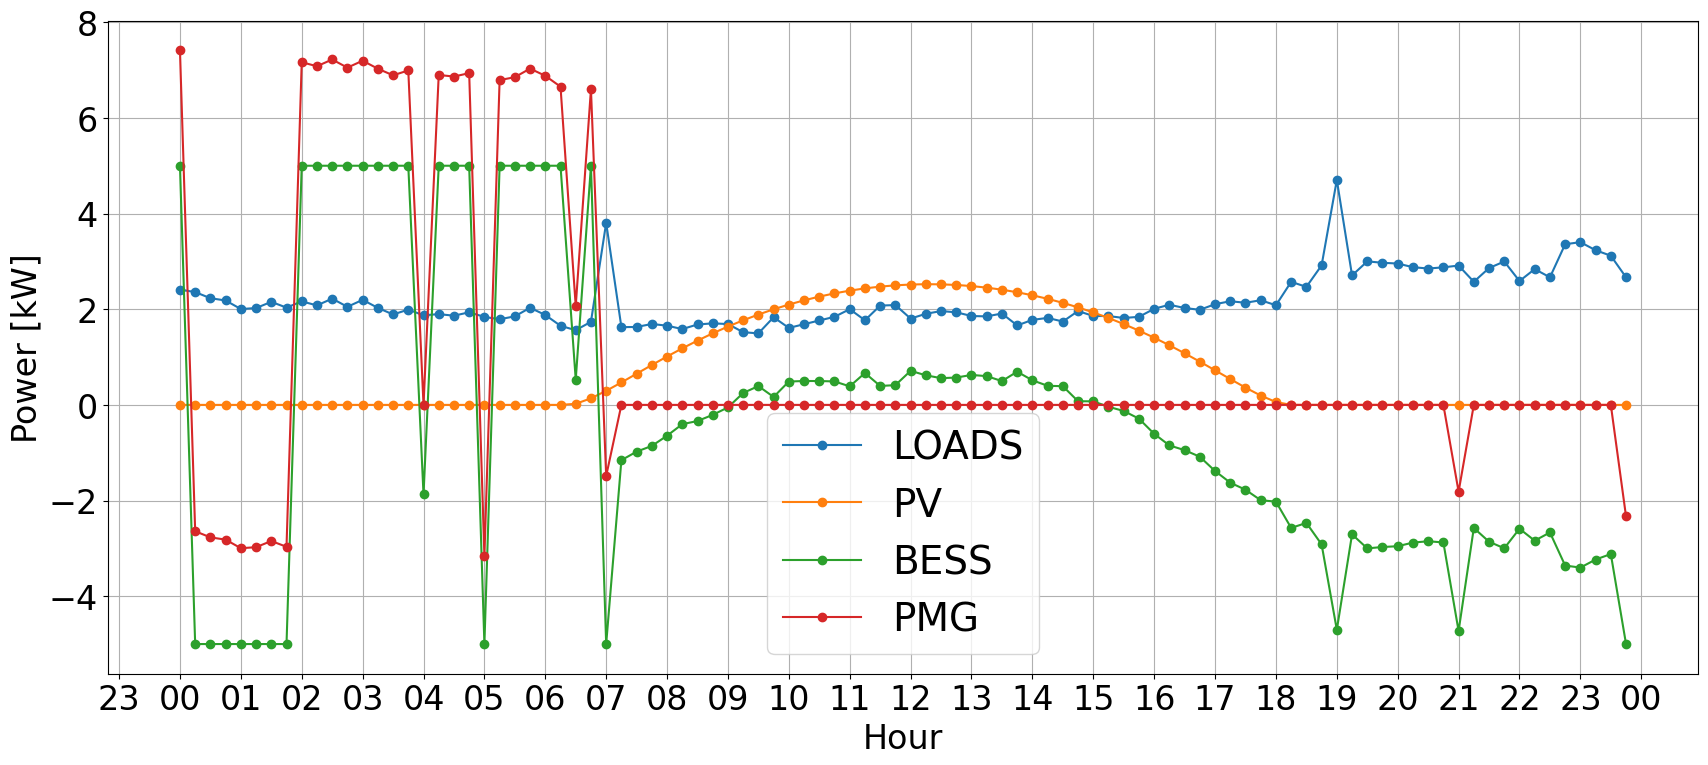

<Figure size 3840x2880 with 0 Axes>

In [12]:
#Plotar resultados
times = np.arange(np.datetime64('2022-07-14 00:00'),
                  np.datetime64('2022-07-14 23:46'), np.timedelta64(15, 'm'))

fig, axs = plt.subplots(1, 1)
sample = 0
axs.plot(times, pic+pin+pfc*np.array(bch[sample])+pfn*np.array(bcm[sample]), times, pfv, times, pbat[sample], times, pmg[sample], marker='o')
axs.set_xlabel('Hour', fontsize=24)
axs.set_ylabel('Power [kW]',fontsize=24)
axs.legend(['LOADS','PV','BESS', 'PMG'],prop={'size': 28})
axs.tick_params(axis='y', which='major', labelsize=24)
axs.tick_params(axis='x', which='major', labelsize=24)
axs.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gca().xaxis.set_minor_locator(mdates.HourLocator())

fig.tight_layout()
plt.figure(dpi=600)
fig.set_size_inches(20, 8.5)
plt.show()

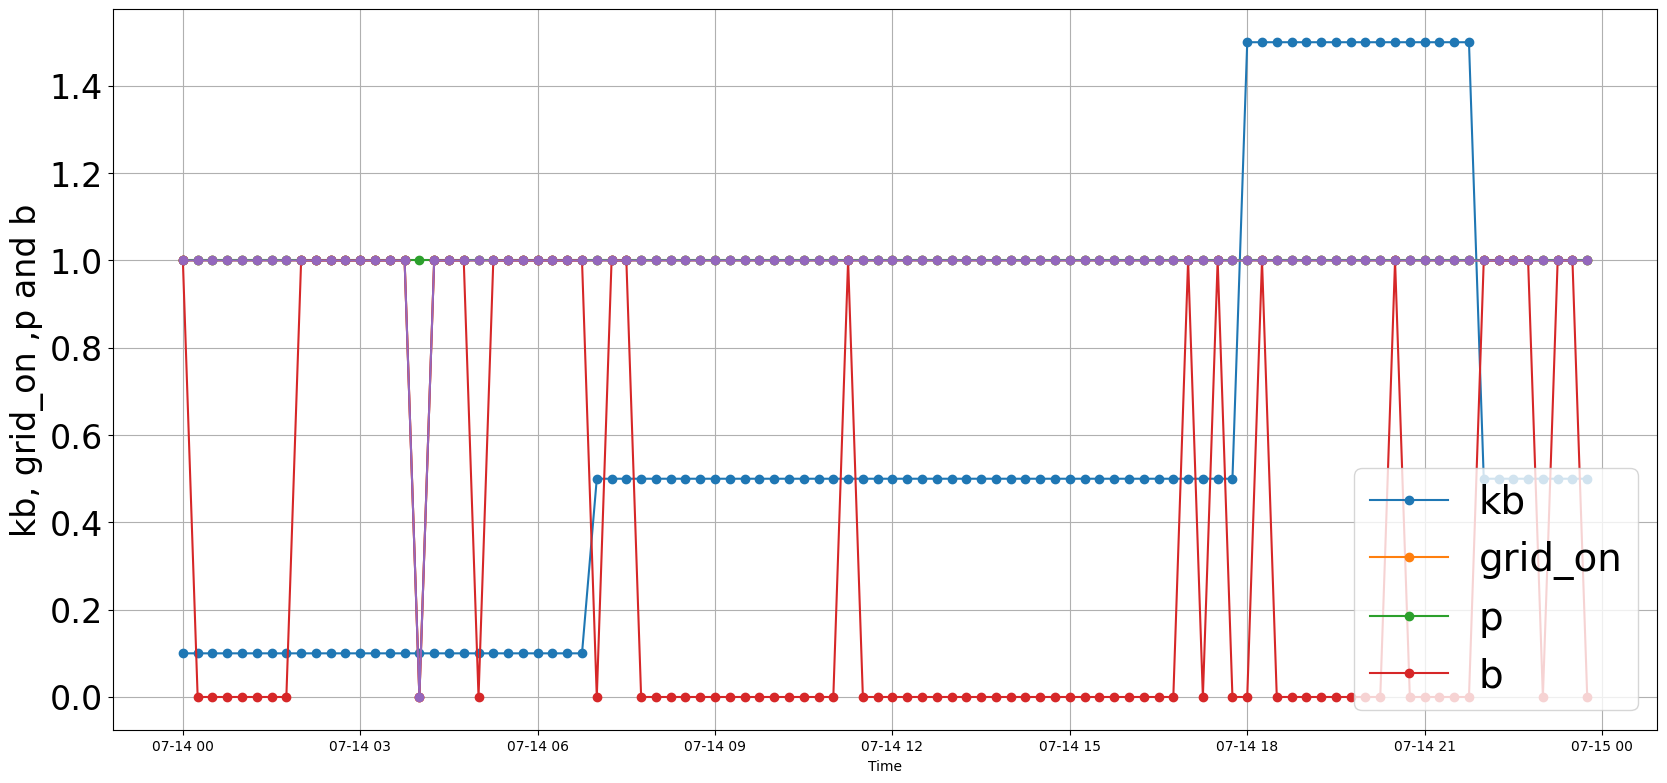

<Figure size 3840x2880 with 0 Axes>

In [13]:
fig, axs = plt.subplots(1, 1)
axs.plot(times, kb, times, list(grid_on[sample]), times, p, times, b[sample], times, grid_on[sample], marker='o')
axs.set_xlabel('Time')
axs.set_ylabel('kb, grid_on ,p and b',fontsize=24)
axs.legend(['kb','grid_on','p', 'b'],prop={'size': 28})
axs.tick_params(axis='y', which='major', labelsize=24)
axs.grid(True)
fig.tight_layout()
plt.figure(dpi=600)
fig.set_size_inches(20, 8.5)
plt.show()

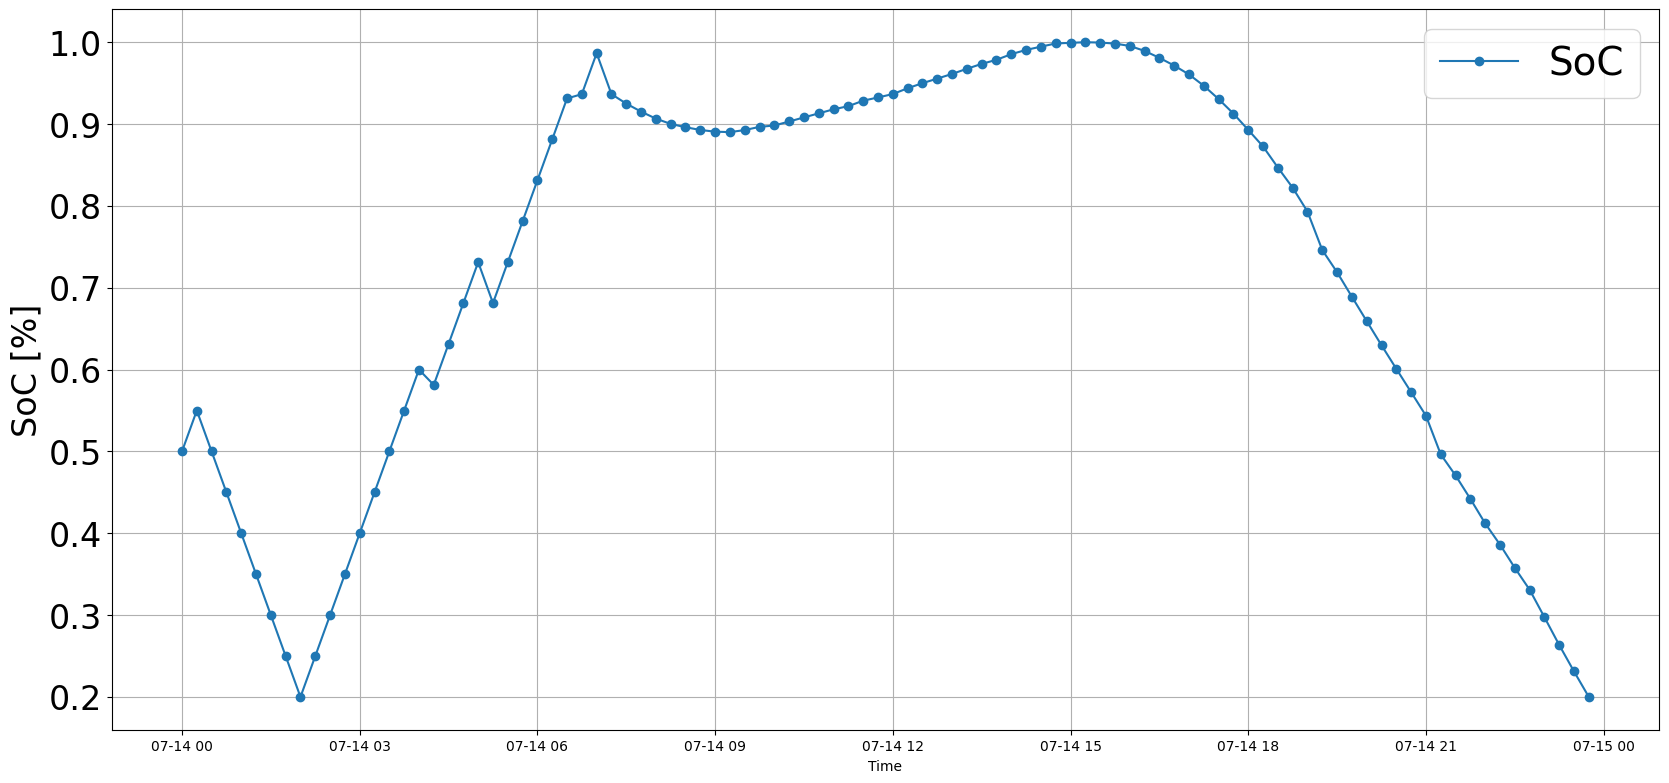

<Figure size 3840x2880 with 0 Axes>

In [14]:
fig, axs = plt.subplots(1, 1)
axs.plot(times, SoCs[sample], marker='o')
axs.set_xlabel('Time')
axs.set_ylabel('SoC [%]',fontsize=24)
axs.legend(['SoC'],prop={'size': 28})
axs.tick_params(axis='y', which='major', labelsize=24)
axs.grid(True)
fig.tight_layout()
plt.figure(dpi=600)
fig.set_size_inches(20, 8.5)
plt.show()